# First Steps Toward Inference

In this document, we are taking our first steps toward inferring the maximum likelihood moderl parameters. First, we'll generate some fake data and let it evolve for one time-step under some set model parameters. We then compute the likelihood function over a range of potential parameters to see if we can find the original ones. In this simple demo we just show a 2-dimensional grid search over some possible values of $\gamma_r$ and $\gamma_u$, keeping other values constant. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from itertools import product
from urban_growth import simulator 
from urban_growth import estimator 
%matplotlib inline

# Generate the Data

In [2]:
# Params

## Initial Configuration
L = 200
rho = .44
blur = 2

## Rural/Urban Size Threshold
T = 50

## Dynamical Parameters, not assuming that these are good ones. 

pars = {'gamma_r' : 2.0,     # rural settlement more diffuse than urban
        'gamma_u' : 3.0,      
        'alpha_r' : 5.0,       
        'alpha_u' : 5.0,
        'beta_r'  : -10.0,      # low background rates
        'beta_u'  : -10.0}

truncation = 20

geo = np.ones((L, L))

for i in np.arange(0, L):
    geo[:,i] = 1.0*i / L 

In [3]:
m = simulator.simulator(geo = geo)
m.set_M0(L = L, density = rho, blur = blur)

densities = m.density(T, pars, 
                      use_geo = True, 
                      stage = 'initial', 
                      truncation = truncation)

prob = densities[0] + densities[1]

M = m.dynamics(T, pars, 
               use_geo = True, 
               n_iters = 1, 
               truncation = truncation)
M1 = M.copy()
M1[np.isfinite(M1)] = 1
M1[np.isnan(M1)] = 0

recalculating distances
recalculating distances


urban_growth/simulator.py:17: RuntimeWarning: invalid value encountered in less
  new_mat = (rands < prob) * 1


## Visualize the data


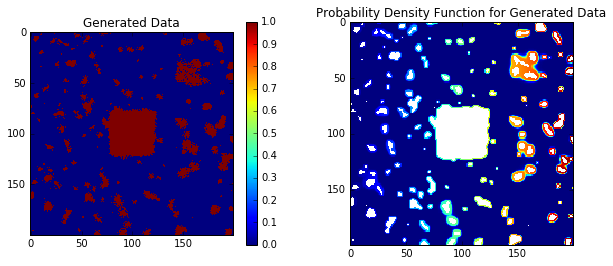

In [4]:
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)
im = ax1.imshow(M1, interpolation = 'nearest')
plt.title('Generated Data')
plt.colorbar(im)

ax2 = fig.add_subplot(122)
ax2.imshow(prob, interpolation = 'nearest')
plt.title('Probability Density Function for Generated Data')

In [5]:
reload(estimator)
e = estimator.estimator(geo = geo)
e.set_M0(M0 = m.get_M0())

# Grid Search Over $\gamma_r$ and $\gamma_u$

Now we'll evaluate the model likelihood on a range of values of $\gamma_r$ and $\gamma_u$ to see if we can recover their true values. 

In [6]:
def test_likelihood(gamma_r, gamma_u):
    internal_pars = pars.copy()
    internal_pars.update({'gamma_r' : gamma_r, 'gamma_u' : gamma_u})
    l1 = e.log_likelihood(M1, 
                 T, 
                 internal_pars, 
                 model_type = 'logistic', 
                 normalized = True, 
                 use_geo    = True, 
                 truncation = truncation)
    return l1

In [7]:
npoints = 13
ax = np.linspace(1, 4, npoints)
coords = product(ax, ax)
test = np.array([test_likelihood(coord[0], coord[1]) for coord in coords])

recalculating distances


urban_growth/estimator.py:19: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X * np.log(prob) + (1 - X) * np.log(1 - prob))
urban_growth/estimator.py:19: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(X * np.log(prob) + (1 - X) * np.log(1 - prob))


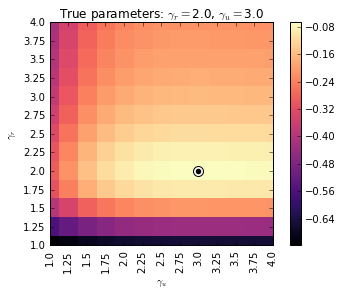

In [8]:
lls = test.reshape(len(ax), len(ax))

plt.imshow(lls, 
           interpolation = 'nearest',
          cmap = 'magma')
plt.colorbar()

ax1 = plt.gca()

ax1.set(xlabel = r'$\gamma_u$', 
       ylabel = r'$\gamma_r$',
       xlim = (1, 4), 
       ylim = (1,4))

ticks = plt.xticks(range(npoints), ax, rotation='vertical')
ticks = plt.yticks(range(npoints), ax, rotation='horizontal')

true_r = np.where(ax == pars['gamma_r'])[0][0]
true_u = np.where(ax == pars['gamma_u'])[0][0]

max_ix = np.unravel_index(lls.argmax(), lls.shape)

plt.scatter(max_ix[1], max_ix[0], c = 'white', s = 100)
plt.scatter(true_u, true_r, color = 'black')

plt.title("True parameters: " + r'$\gamma_r = $' + str(pars['gamma_r']) + ', ' + r'$\gamma_u = $' + str(pars['gamma_u']))

Overall this result is heartening -- the likelihood is indeed maximized at the true values for $\gamma_r$ and $\gamma_u$. It's a bit concerning that the model doesn't have a strong opinion about the correct value of $\gamma_r$, though. 

The extra mathematical work comes when we want to estimate all the model parameters simultaneously and to higher levels of precision. 